# Preparation

In [1]:
"""
# Download model
huggingface-cli download tiiuae/Falcon3-3B-Instruct-1.58bit --local-dir ~/models/tiiuae/Falcon3-3B-Instruct-1.58bit
# Compile
cmake -S . -B build -G Ninja \
  -DCMAKE_BUILD_TYPE=Release \
  -DCMAKE_C_COMPILER=clang -DCMAKE_CXX_COMPILER=clang++ \
  -DGGML_NATIVE=OFF \
  -DGGML_AVX=ON -DGGML_AVX2=ON \
  -DGGML_AVX512=ON \
  -DGGML_AVX512_VNNI=ON \
  -DGGML_AVX512_BF16=ON \
  -DGGML_AVX512_VBMI=OFF
python setup_env.py -md ~/models/tiiuae/Falcon3-3B-Instruct-1.58bit -q i2_s --quant-embd
"""

'\n# Download model\nhuggingface-cli download tiiuae/Falcon3-3B-Instruct-1.58bit --local-dir ~/models/tiiuae/Falcon3-3B-Instruct-1.58bit\n# Compile\ncmake -S . -B build -G Ninja   -DCMAKE_BUILD_TYPE=Release   -DCMAKE_C_COMPILER=clang -DCMAKE_CXX_COMPILER=clang++   -DGGML_NATIVE=OFF   -DGGML_AVX=ON -DGGML_AVX2=ON   -DGGML_AVX512=ON   -DGGML_AVX512_VNNI=ON   -DGGML_AVX512_BF16=ON   -DGGML_AVX512_VBMI=OFF\npython setup_env.py -md ~/models/tiiuae/Falcon3-3B-Instruct-1.58bit -q i2_s --quant-embd\n'

# Importing Libraries

In [2]:
import gc
from dataclasses import dataclass
import torch
from transformers import AutoModelForCausalLM
from utils import set_seed
from speculative_decoding import BitNet

# Configuration

In [3]:
@dataclass
class CONFIG:
    # Debug
    debug: bool = False
    verbose: bool = True

    # Model
    ## Tokenizer
    tokenizer_id: str = "tiiuae/Falcon3-1B-Instruct"
    ## HuggingFace
    model_path: str       = "/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct"  # 3B
    model_small_path: str = "/home/pathfinder/models/tiiuae/Falcon3-1B-Instruct"  # 1B
    ## GGUF (1bit)
    bitnet_path: str = "/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct-1.58bit/ggml-model-i2_s.gguf" # 3B
    ctx_size: int = 256

    # Generation
    max_new_tokens: int = 100
    ## Speculative Decoding
    num_assistant_tokens: int = 5
    confidence_threshold: float = 0.4

    # Device
    device = "cpu"
    n_threads: int = 12

    # Seed
    seed = 42

config = CONFIG()

In [4]:
set_seed(config.seed)

Random seed set to 42


In [5]:
system_prompt = "You are a helpful AI assistant."
user_prompt = "Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?"
assistant_response = "The problem asks for the number of rational numbers between 0 and 1 such that when the rational number is written as a fraction in lowest terms, the product of the numerator and the denominator is $20!$."

# Model

In [6]:
bitnet = BitNet()
bitnet.start_server(
    bitnet_path=config.bitnet_path,
    ctx_size=config.ctx_size,
    n_threads=config.n_threads,
    verbose=config.verbose
)
bitnet.init_tokenizer(
    tokenizer_id=config.tokenizer_id,
    verbose=False
)
bitnet.init_model(
    model_path=config.model_path,
    device=config.device,
    verbose=True
)

🚀 Starting llama-server on 127.0.0.1:8080
✅ Server is ready.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(131072, 3072)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (up_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=3072, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e-06)
    (

# Generation

In [7]:
# 32bit-1bit
bitnet.speculative_decode(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    max_new_tokens=config.max_new_tokens,
    num_assistant_tokens=config.num_assistant_tokens,
    confidence_threshold=config.confidence_threshold,
    verbose=True
)
gc.collect()
torch.cuda.empty_cache()


──────────────────────────────────────────────────
✨ Speculative Decoding
├─ Target Model: /home/pathfinder/models/tiiuae/Falcon3-3B-Instruct
├─ Draft Model: /home/pathfinder/models/tiiuae/Falcon3-3B-Instruct-1.58bit/ggml-model-i2_s.gguf
└─ Draft Length: 5, Confidence: 0.4
──────────────────────────────────────────────────

----------Step 1----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>

Draft Output
To solve this problem,
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ To              │       50.95% │ ✅ Accepted        │ -    

In [8]:
text = bitnet.format_falcon_prompt(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    #assistant_response=assistant_response
)
print(text)

<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>



In [9]:
# 3B (1bit)
bitnet.generate_gguf(
    text=text,
    max_new_tokens=config.max_new_tokens,
    verbose=config.verbose
)


──────────────────────────────────────────────────
🧠 Generation Info (BitNet GGUF)
──────────────────────────────────────────────────
💬 User Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>


🟢 Generated Text:
Given a rational number, we can write it in its lowest terms as r/p, where p is the common denominator. Then, rewrite $20!$ in terms of p.
$20! = 20 * 19 * 18 * ... 2 * 1 * 1$
To calculate the product of a sequence of numbers, we can multiply them all together but if they are fractions, we need to multiply

📊 Timings:
├─ Prefill: 4.30 ms/token, 232.77 tokens/s
└─ Decode: 52.05 ms/token, 19.21 tokens/s
📦 Tokens:
├─ Prefilled: 75
└─ Decoded: 100
🛑 Stop Reason: Limit

──────────────────────────────────────────────────
💡 Token Probabilitie

'Given a rational number, we can write it in its lowest terms as r/p, where p is the common denominator. Then, rewrite $20!$ in terms of p.\n$20! = 20 * 19 * 18 * ... 2 * 1 * 1$\nTo calculate the product of a sequence of numbers, we can multiply them all together but if they are fractions, we need to multiply'

In [10]:
# 3B (fp32)
bitnet.generate_hf(
    text=text,
    max_new_tokens=config.max_new_tokens,
    stream=True,
    verbose=config.verbose
)

<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Let's start by calculating \(20!\):

\[ 20! = 20 

──────────────────────────────────────────────────
🧠 Generation Info (Hugging Face)
──────────────────────────────────────────────────
💬 User Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rationa

"To solve this problem, we need to follow these steps:\n\n1. Identify the rational numbers between 0 and 1.\n2. Write each rational number as a fraction in its lowest terms.\n3. Calculate the product of the numerator and denominator for each fraction.\n4. Determine how many of these products equal \\(20!\\).\n\nLet's start by calculating \\(20!\\):\n\n\\[ 20! = 20 "

In [11]:
gc.collect()
torch.cuda.empty_cache()

## Speculative Decoding

In [12]:
bitnet.speculative_decode2(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    max_new_tokens=config.max_new_tokens,
    num_assistant_tokens=config.num_assistant_tokens,
    confidence_threshold=config.confidence_threshold,
    verbose=True
)
gc.collect()
torch.cuda.empty_cache()


──────────────────────────────────────────────────
✨ Speculative Decoding
├─ Target Model: /home/pathfinder/models/tiiuae/Falcon3-3B-Instruct
├─ Draft Model: /home/pathfinder/models/tiiuae/Falcon3-3B-Instruct-1.58bit/ggml-model-i2_s.gguf
└─ Draft Length: 5, Confidence: 0.400
──────────────────────────────────────────────────

---------- Step 1 ----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>

Draft Output:
To solve this problem,
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
└─────┴─────────────────┴──────────────┴────────────────────┴

In [13]:
# 3B-1B
bitnet.generate_hf(
    small_model=AutoModelForCausalLM.from_pretrained(
        config.model_small_path,
        device_map=config.device,
        dtype=torch.float32
    ),
    text=text,
    max_new_tokens=config.max_new_tokens,
    num_assistant_tokens=config.num_assistant_tokens,
    confidence_threshold=config.confidence_threshold,
    stream=True,
    verbose=True
)
gc.collect()
torch.cuda.empty_cache()

<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Let's start by calculating \(20!\):

\[ 20! = 20 

──────────────────────────────────────────────────
🧠 Generation Info (Hugging Face)
──────────────────────────────────────────────────
💬 User Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rationa

In [14]:
# 3B-1B
bitnet.speculative_decoding_hf(
    small_model=AutoModelForCausalLM.from_pretrained(
        config.model_small_path,
        device_map=config.device,
        dtype=torch.float32
    ),
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    max_new_tokens=config.max_new_tokens,
    num_assistant_tokens=config.num_assistant_tokens,
    confidence_threshold=config.confidence_threshold,
    verbose=True
)
gc.collect()
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



──────────────────────────────────────────────────
✨ Speculative Decoding
├─ Target Model: /home/pathfinder/models/tiiuae/Falcon3-3B-Instruct
├─ Draft Model: /home/pathfinder/models/tiiuae/Falcon3-1B-Instruct
└─ Draft Length: 5, Confidence: 0.4
──────────────────────────────────────────────────


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 1----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?

Draft Output
<|assistant|>

┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ <               │      100.00% │ ✅ Accepted        │ -               │
│ 2   │ |               │      100.00% │ ✅ Accepted        │ -               │
│ 3   │ assistant       │      100.00% │ ✅ Accepted        │ -               │
│ 4   │ |>              │      100.00% │ ✅ Accepted        │ -               │
│ 5   │ \n              │      100.00% │ ✅ Accepted        │ -               │
└─────┴────────────

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 2----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To
Draft Output
 solve this problem, we
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  solve          │       90.90% │ ✅ Accepted        │ -               │
│ 2   │  this           │       87.17% │ ✅ Accepted        │ -               │
│ 3   │  problem        │       97.62% │ ✅ Accepted        │ -               │
│ 4   │ ,               │       99.45% │ ✅ Accepted        │ -               │
│ 5   │  we             │       69.94% │ ✅ Accepted        │ -           

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 3----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need
Draft Output
 to follow these steps:
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  to             │       99.87% │ ✅ Accepted        │ -               │
│ 2   │  follow         │       45.11% │ ✅ Accepted        │ -               │
│ 3   │  these          │       89.37% │ ✅ Accepted        │ -               │
│ 4   │  steps          │       99.89% │ ✅ Accepted        │ -               │
│ 5   │ :               │       99.73% │ ✅ Ac

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 4----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

Draft Output

1. **
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ \n              │       99.02% │ ✅ Accepted        │ -               │
│ 2   │ 1               │       98.56% │ ✅ Accepted        │ -               │
│ 3   │ .               │       99.99% │ ✅ Accepted        │ -               │
│ 4   │                 │       32.66% │ ❌ Rejected        │  Identify       │
└─────┴─────────────────┴─────────────

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 5----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify
Draft Output
 a rational number between 
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  a              │       11.82% │ ❌ Rejected        │  the            │
└─────┴─────────────────┴──────────────┴────────────────────┴─────────────────┘


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 6----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the
Draft Output
 rational number between 0
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  rational       │       81.74% │ ✅ Accepted        │ -               │
│ 2   │  number         │        4.22% │ ❌ Rejected        │  numbers        │
└─────┴─────────────────┴──────────────┴────────────────────┴─────────────────┘


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 7----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers
Draft Output
 between 0 and 
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  between        │       99.34% │ ✅ Accepted        │ -               │
│ 2   │                 │      100.00% │ ✅ Accepted        │ -               │
│ 3   │ 0               │       99.93% │ ✅ Accepted        │ -               │
│ 4   │  and            │       99.99% │ ✅ Accepted        │ -             

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 8----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1
Draft Output
.
2. Convert
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ .               │       57.63% │ ✅ Accepted        │ -               │
│ 2   │ \n              │       88.74% │ ✅ Accepted        │ -               │
│ 3   │ 2               │       99.77% │ ✅ Accepted        │ -               │
│ 4   │ .               │      100.00% │ ✅ Accepted        │ -

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 9----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write
Draft Output
 each rational number as a
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  each           │       89.92% │ ✅ Accepted        │ -               │
│ 2   │  rational       │       71.09% │ ✅ Accepted        │ -               │
│ 3   │  number         │      100.00% │ ✅ Accepted        │ -               │
│ 4   │  as             │       58.29%

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 10----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction
Draft Output
 in its lowest terms.
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  in             │       99.57% │ ✅ Accepted        │ -               │
│ 2   │  its            │       55.11% │ ✅ Accepted        │ -               │
│ 3   │  lowest         │       93.84% │ ✅ Accepted        │ -               │
│ 4   │

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 11----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.

Draft Output
3. Calculate the product
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ 3               │      100.00% │ ✅ Accepted        │ -               │
│ 2   │ .               │      100.00% │ ✅ Accepted        │ -               │
│ 3   │  Calculate      │       89.57% │ ✅ Accepted        │ 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 12----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of
Draft Output
 the numerator and denominator for
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  the            │       99.71% │ ✅ Accepted        │ -               │
│ 2   │  numerator      │       92.70% │ ✅ Accepted        │ -               │
│ 3   │  and            

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 13----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each
Draft Output
 rational number.
4
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  rational       │        2.76% │ ❌ Rejected        │  fraction       │
└─────┴─────────────────┴──────────────┴────────────────────┴─────────────────┘

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 14----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction
Draft Output
.
4. Determine
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ .               │       99.02% │ ✅ Accepted        │ -               │
│ 2   │ \n              │       99.95% │ ✅ Accepted        │ -             

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 15----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how
Draft Output
 many of these products equal
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  many           │       99.69% │ ✅ Accepted        │ -               │
│ 2   │  of             │       83.45% │ ✅

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 16----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal 
Draft Output
\(20!\).
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ \(              │       79.76% │ ✅ Accepted        │ -               │
│ 2   │ 2               │       9

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 17----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Draft Output

Let's start
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ \n              │       99.95% │ ✅ Accepted        │ -               │
│ 2   │ Let         

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 18----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Let's start by
Draft Output
 identifying the rational numbers between
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │  identifying    │        5.53% │ ❌ Rejected    

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 19----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Let's start by calculating
Draft Output
 \(20!\
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │                 │       98.58% │ ✅ Accepted        │ -               

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



----------Step 20----------
Draft Input:
<|system|>
You are a helpful AI assistant.
<|user|>
	Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?
<|assistant|>
To solve this problem, we need to follow these steps:

1. Identify the rational numbers between 0 and 1.
2. Write each rational number as a fraction in its lowest terms.
3. Calculate the product of the numerator and denominator for each fraction.
4. Determine how many of these products equal \(20!\).

Let's start by calculating \(20!\):
Draft Output


\[ 2
┌─────┬─────────────────┬──────────────┬────────────────────┬─────────────────┐
│ Idx │ Draft Token     │  Target Prob │ Status             │ Corrected       │
├─────┼─────────────────┼──────────────┼────────────────────┼─────────────────┤
│ 1   │ \n              │       99.54% │ ✅ Accepted        │ -       

In [15]:
# 32bit-2bit


📊 Speculative Decoding Results
NumDraft | Threshold |   AcceptRate(%) |  Latency(ms/token)
-----------------------------------------------------------------
       2 |      0.10 |           90.28 |             959.80
       2 |      0.20 |           88.89 |             967.19
       2 |      0.30 |           91.67 |             934.44
       2 |      0.40 |           87.84 |             947.95
       2 |      0.50 |           87.84 |             955.26
       3 |      0.10 |           80.00 |             777.96
       3 |      0.20 |           80.00 |             771.01
       3 |      0.30 |           85.06 |             769.93
       3 |      0.40 |           73.96 |             840.04
       3 |      0.50 |           73.96 |             838.73
       4 |      0.10 |           79.17 |             644.52
       4 |      0.20 |           79.00 |             679.23
       4 |      0.30 |           90.91 |             576.37
       4 |      0.40 |           81.25 |             633.36
  

/tmp/ipykernel_143152/2299133353.py:74: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.08)


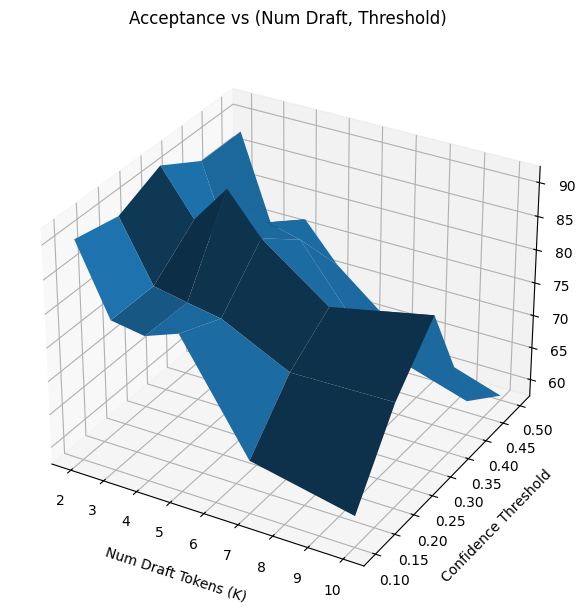

/tmp/ipykernel_143152/2299133353.py:91: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.08)


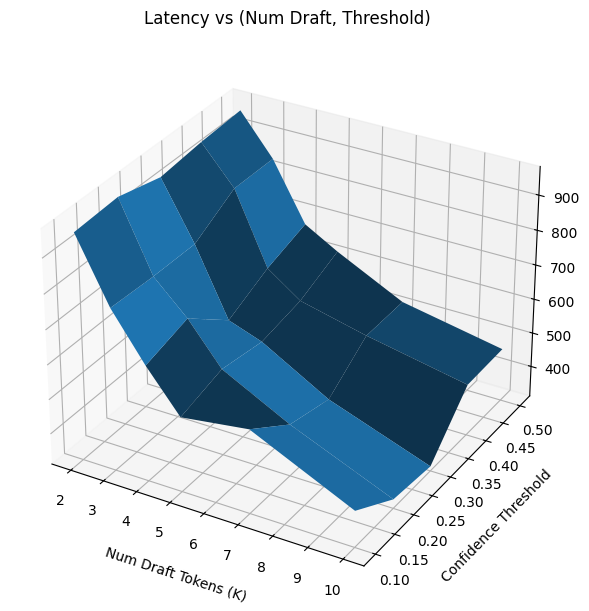

Saved figures: acceptance_surface.png, latency_surface.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (필요한 side-effect import)
import matplotlib as mpl

# 전역 레이아웃 옵션: 3D에서 tight_layout 대신 constrained layout 권장
mpl.rcParams["figure.constrained_layout.use"] = True

# ===================== 사용자 설정 =====================
K_list = [2, 3, 4, 5, 7, 10]               # num_draft 후보
T_list = [0.1, 0.2, 0.3, 0.4, 0.5]         # threshold 후보
SYSTEM_PROMPT = "You are a helpful AI assistant."
USER_PROMPT = "Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?"
MAX_NEW_TOKENS = 100
SEED = 42
USE_MOCK = False  # True면 speculative_decode가 없어도 랜덤 테스트 가능
# =====================================================

def run_once(num_draft: int, threshold: float):
    """(num_draft, threshold) 조합 → acceptance_rate(%)와 latency(ms/token)"""
    if USE_MOCK:
        rng = np.random.default_rng(1234 + num_draft * 17 + int(threshold * 100))
        base_accept = 80 - 10*(threshold*10 - 3.0)**2 - 2*(num_draft - 3) + rng.normal(0, 2)
        base_accept = float(np.clip(base_accept, 5, 98))
        base_latency = 25 + 4*(num_draft - 2) + 30*(threshold - 0.2) + rng.normal(0, 1.5)
        base_latency = float(max(1.0, base_latency))
        return base_accept, base_latency

    out = bitnet.speculative_decode(
        system_prompt=SYSTEM_PROMPT,
        user_prompt=USER_PROMPT,
        num_assistant_tokens=num_draft,
        confidence_threshold=threshold,
        verbose=False,
        max_new_tokens=MAX_NEW_TOKENS,
        seed=SEED
    )
    return float(out["acceptance_rate"]), float(out["latency"])

# 결과 행렬
K = np.array(K_list, dtype=float)
T = np.array(T_list, dtype=float)
KK, TT = np.meshgrid(K, T, indexing="ij")
ACC = np.zeros_like(KK, dtype=float)
LAT = np.zeros_like(KK, dtype=float)

print("\n📊 Speculative Decoding Results")
print("="*65)
print(f"{'NumDraft':>8s} | {'Threshold':>9s} | {'AcceptRate(%)':>15s} | {'Latency(ms/token)':>18s}")
print("-"*65)

for i, k in enumerate(K_list):
    for j, t in enumerate(T_list):
        acc, lat = run_once(k, t)
        ACC[i, j] = acc
        LAT[i, j] = lat
        print(f"{k:>8d} | {t:>9.2f} | {acc:>15.2f} | {lat:>18.2f}")

print("="*65)

# ---- 3D 그래프 1: Acceptance Rate ----
fig1 = plt.figure(figsize=(8, 6), constrained_layout=True)
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(KK, TT, ACC, rstride=1, cstride=1, linewidth=0.3, antialiased=True)

# 레이블/타이틀 패딩 및 틱 패딩으로 잘림 방지
ax1.set_xlabel("Num Draft Tokens (K)", labelpad=10)
ax1.set_ylabel("Confidence Threshold", labelpad=10)
ax1.set_zlabel("Acceptance Rate (%)", labelpad=12)
ax1.set_title("Acceptance vs (Num Draft, Threshold)", pad=16)
ax1.tick_params(pad=4)

# 추가 여백 보정
fig1.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.08)

# 파일 저장 시 잘림 방지
fig1.savefig("acceptance_surface.png", bbox_inches="tight", dpi=200)
plt.show()

# ---- 3D 그래프 2: Latency ----
fig2 = plt.figure(figsize=(8, 6), constrained_layout=True)
ax2 = fig2.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(KK, TT, LAT, rstride=1, cstride=1, linewidth=0.3, antialiased=True)

ax2.set_xlabel("Num Draft Tokens (K)", labelpad=10)
ax2.set_ylabel("Confidence Threshold", labelpad=10)
ax2.set_zlabel("Latency (ms/token)", labelpad=12)
ax2.set_title("Latency vs (Num Draft, Threshold)", pad=16)
ax2.tick_params(pad=4)

fig2.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.08)
fig2.savefig("latency_surface.png", bbox_inches="tight", dpi=200)
plt.show()

print("Saved figures: acceptance_surface.png, latency_surface.png")

# Evaluation

In [17]:
"""
lm_eval --model hf \
    --model_args pretrained=/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct,trust_remote_code=True \
    --tasks mmlu,hellaswag,gsm8k_cot,arc_easy \
    --num_fewshot 5 \
    --device cuda:0 \
    --batch_size 4 \
    --seed 1234 \
    --apply_chat_template \
    --output_path results \
    --log_samples \
    --wandb_args project=lm-eval-harness-integration

lm_eval --model hf \
    --model_args pretrained=/home/pathfinder/models/tiiuae/Falcon3-1B-Instruct,trust_remote_code=True \
    --tasks mmlu,hellaswag,gsm8k_cot,arc_easy \
    --num_fewshot 5 \
    --device cuda:0 \
    --batch_size 4 \
    --seed 1234 \
    --apply_chat_template \
    --output_path results \
    --log_samples \
    --wandb_args project=lm-eval-harness-integration

lm_eval --model hf \
    --model_args pretrained=tiiuae/Falcon3-3B-Instruct-1.58bit,trust_remote_code=True \
    --tasks mmlu,hellaswag,gsm8k_cot,arc_easy \
    --num_fewshot 5 \
    --device cuda:0 \
    --batch_size 4 \
    --seed 1234 \
    --apply_chat_template \
    --output_path results \
    --log_samples \
    --wandb_args project=lm-eval-harness-integration
"""

'\nlm_eval --model hf     --model_args pretrained=/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct,trust_remote_code=True     --tasks mmlu,hellaswag,gsm8k_cot,arc_easy     --num_fewshot 5     --device cuda:0     --batch_size 4     --seed 1234     --apply_chat_template     --output_path results     --log_samples     --wandb_args project=lm-eval-harness-integration\n\nlm_eval --model hf     --model_args pretrained=/home/pathfinder/models/tiiuae/Falcon3-1B-Instruct,trust_remote_code=True     --tasks mmlu,hellaswag,gsm8k_cot,arc_easy     --num_fewshot 5     --device cuda:0     --batch_size 4     --seed 1234     --apply_chat_template     --output_path results     --log_samples     --wandb_args project=lm-eval-harness-integration\n\nlm_eval --model hf     --model_args pretrained=tiiuae/Falcon3-3B-Instruct-1.58bit,trust_remote_code=True     --tasks mmlu,hellaswag,gsm8k_cot,arc_easy     --num_fewshot 5     --device cuda:0     --batch_size 4     --seed 1234     --apply_chat_template     --out

In [18]:
"""
hf (pretrained=/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4
|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|arc_easy                               |      1|none            |     5|acc        |↑  |0.7639|±  |0.0087|
|                                       |       |none            |     5|acc_norm   |↑  |0.7719|±  |0.0086|
|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.7013|±  |0.0126|
|                                       |       |strict-match    |     5|exact_match|↑  |0.7005|±  |0.0126|
|hellaswag                              |      1|none            |     5|acc        |↑  |0.5227|±  |0.0050|
|                                       |       |none            |     5|acc_norm   |↑  |0.6846|±  |0.0046|
|mmlu                                   |      2|none            |      |acc        |↑  |0.5631|±  |0.0040|
| - humanities                          |      2|none            |      |acc        |↑  |0.4869|±  |0.0068|
|  - formal_logic                       |      1|none            |     5|acc        |↑  |0.4524|±  |0.0445|
|  - high_school_european_history       |      1|none            |     5|acc        |↑  |0.6606|±  |0.0370|
|  - high_school_us_history             |      1|none            |     5|acc        |↑  |0.7157|±  |0.0317|
|  - high_school_world_history          |      1|none            |     5|acc        |↑  |0.7300|±  |0.0289|
|  - international_law                  |      1|none            |     5|acc        |↑  |0.7190|±  |0.0410|
|  - jurisprudence                      |      1|none            |     5|acc        |↑  |0.7037|±  |0.0441|
|  - logical_fallacies                  |      1|none            |     5|acc        |↑  |0.7239|±  |0.0351|
|  - moral_disputes                     |      1|none            |     5|acc        |↑  |0.6416|±  |0.0258|
|  - moral_scenarios                    |      1|none            |     5|acc        |↑  |0.2235|±  |0.0139|
|  - philosophy                         |      1|none            |     5|acc        |↑  |0.6463|±  |0.0272|
|  - prehistory                         |      1|none            |     5|acc        |↑  |0.6049|±  |0.0272|
|  - professional_law                   |      1|none            |     5|acc        |↑  |0.3748|±  |0.0124|
|  - world_religions                    |      1|none            |     5|acc        |↑  |0.7661|±  |0.0325|
| - other                               |      2|none            |      |acc        |↑  |0.6154|±  |0.0086|
|  - business_ethics                    |      1|none            |     5|acc        |↑  |0.5700|±  |0.0498|
|  - clinical_knowledge                 |      1|none            |     5|acc        |↑  |0.5962|±  |0.0302|
|  - college_medicine                   |      1|none            |     5|acc        |↑  |0.5954|±  |0.0374|
|  - global_facts                       |      1|none            |     5|acc        |↑  |0.3700|±  |0.0485|
|  - human_aging                        |      1|none            |     5|acc        |↑  |0.6457|±  |0.0321|
|  - management                         |      1|none            |     5|acc        |↑  |0.6990|±  |0.0454|
|  - marketing                          |      1|none            |     5|acc        |↑  |0.7821|±  |0.0270|
|  - medical_genetics                   |      1|none            |     5|acc        |↑  |0.6500|±  |0.0479|
|  - miscellaneous                      |      1|none            |     5|acc        |↑  |0.7011|±  |0.0164|
|  - nutrition                          |      1|none            |     5|acc        |↑  |0.6111|±  |0.0279|
|  - professional_accounting            |      1|none            |     5|acc        |↑  |0.4681|±  |0.0298|
|  - professional_medicine              |      1|none            |     5|acc        |↑  |0.5257|±  |0.0303|
|  - virology                           |      1|none            |     5|acc        |↑  |0.4940|±  |0.0389|
| - social sciences                     |      2|none            |      |acc        |↑  |0.6422|±  |0.0085|
|  - econometrics                       |      1|none            |     5|acc        |↑  |0.5088|±  |0.0470|
|  - high_school_geography              |      1|none            |     5|acc        |↑  |0.6869|±  |0.0330|
|  - high_school_government_and_politics|      1|none            |     5|acc        |↑  |0.6736|±  |0.0338|
|  - high_school_macroeconomics         |      1|none            |     5|acc        |↑  |0.5513|±  |0.0252|
|  - high_school_microeconomics         |      1|none            |     5|acc        |↑  |0.6681|±  |0.0306|
|  - high_school_psychology             |      1|none            |     5|acc        |↑  |0.7468|±  |0.0186|
|  - human_sexuality                    |      1|none            |     5|acc        |↑  |0.6183|±  |0.0426|
|  - professional_psychology            |      1|none            |     5|acc        |↑  |0.5441|±  |0.0201|
|  - public_relations                   |      1|none            |     5|acc        |↑  |0.5818|±  |0.0472|
|  - security_studies                   |      1|none            |     5|acc        |↑  |0.6980|±  |0.0294|
|  - sociology                          |      1|none            |     5|acc        |↑  |0.7413|±  |0.0310|
|  - us_foreign_policy                  |      1|none            |     5|acc        |↑  |0.7300|±  |0.0446|
| - stem                                |      2|none            |      |acc        |↑  |0.5480|±  |0.0086|
|  - abstract_algebra                   |      1|none            |     5|acc        |↑  |0.3000|±  |0.0461|
|  - anatomy                            |      1|none            |     5|acc        |↑  |0.5333|±  |0.0431|
|  - astronomy                          |      1|none            |     5|acc        |↑  |0.6908|±  |0.0376|
|  - college_biology                    |      1|none            |     5|acc        |↑  |0.7222|±  |0.0375|
|  - college_chemistry                  |      1|none            |     5|acc        |↑  |0.5500|±  |0.0500|
|  - college_computer_science           |      1|none            |     5|acc        |↑  |0.5200|±  |0.0502|
|  - college_mathematics                |      1|none            |     5|acc        |↑  |0.3800|±  |0.0488|
|  - college_physics                    |      1|none            |     5|acc        |↑  |0.4412|±  |0.0494|
|  - computer_security                  |      1|none            |     5|acc        |↑  |0.7500|±  |0.0435|
|  - conceptual_physics                 |      1|none            |     5|acc        |↑  |0.6340|±  |0.0315|
|  - electrical_engineering             |      1|none            |     5|acc        |↑  |0.6345|±  |0.0401|
|  - elementary_mathematics             |      1|none            |     5|acc        |↑  |0.4815|±  |0.0257|
|  - high_school_biology                |      1|none            |     5|acc        |↑  |0.6968|±  |0.0261|
|  - high_school_chemistry              |      1|none            |     5|acc        |↑  |0.5665|±  |0.0349|
|  - high_school_computer_science       |      1|none            |     5|acc        |↑  |0.6700|±  |0.0473|
|  - high_school_mathematics            |      1|none            |     5|acc        |↑  |0.3704|±  |0.0294|
|  - high_school_physics                |      1|none            |     5|acc        |↑  |0.4636|±  |0.0407|
|  - high_school_statistics             |      1|none            |     5|acc        |↑  |0.5139|±  |0.0341|
|  - machine_learning                   |      1|none            |     5|acc        |↑  |0.4464|±  |0.0472|

|      Groups      |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|------------------|------:|------|------|------|---|-----:|---|-----:|
|mmlu              |      2|none  |      |acc   |↑  |0.5631|±  |0.0040|
| - humanities     |      2|none  |      |acc   |↑  |0.4869|±  |0.0068|
| - other          |      2|none  |      |acc   |↑  |0.6154|±  |0.0086|
| - social sciences|      2|none  |      |acc   |↑  |0.6422|±  |0.0085|
| - stem           |      2|none  |      |acc   |↑  |0.5480|±  |0.0086|
"""

'\nhf (pretrained=/home/pathfinder/models/tiiuae/Falcon3-3B-Instruct,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4\n|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|\n|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|\n|arc_easy                               |      1|none            |     5|acc        |↑  |0.7639|±  |0.0087|\n|                                       |       |none            |     5|acc_norm   |↑  |0.7719|±  |0.0086|\n|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.7013|±  |0.0126|\n|                                       |       |strict-match    |     5|exact_match|↑  |0.7005|±  |0.0126|\n|hellaswag                              |      1|none            |     5|acc        |↑  |0.5227|±  |0.0050|\n|                                       |       |none            |     5|acc_no

In [19]:
"""
hf (pretrained=/home/pathfinder/models/tiiuae/Falcon3-1B-Instruct,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4
|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|arc_easy                               |      1|none            |     5|acc        |↑  |0.7378|±  |0.0090|
|                                       |       |none            |     5|acc_norm   |↑  |0.7285|±  |0.0091|
|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.4071|±  |0.0135|
|                                       |       |strict-match    |     5|exact_match|↑  |0.4026|±  |0.0135|
|hellaswag                              |      1|none            |     5|acc        |↑  |0.4648|±  |0.0050|
|                                       |       |none            |     5|acc_norm   |↑  |0.6009|±  |0.0049|
|mmlu                                   |      2|none            |      |acc        |↑  |0.4474|±  |0.0041|
| - humanities                          |      2|none            |      |acc        |↑  |0.4049|±  |0.0069|
|  - formal_logic                       |      1|none            |     5|acc        |↑  |0.3333|±  |0.0422|
|  - high_school_european_history       |      1|none            |     5|acc        |↑  |0.6000|±  |0.0383|
|  - high_school_us_history             |      1|none            |     5|acc        |↑  |0.5588|±  |0.0348|
|  - high_school_world_history          |      1|none            |     5|acc        |↑  |0.6160|±  |0.0317|
|  - international_law                  |      1|none            |     5|acc        |↑  |0.5537|±  |0.0454|
|  - jurisprudence                      |      1|none            |     5|acc        |↑  |0.4630|±  |0.0482|
|  - logical_fallacies                  |      1|none            |     5|acc        |↑  |0.4847|±  |0.0393|
|  - moral_disputes                     |      1|none            |     5|acc        |↑  |0.5231|±  |0.0269|
|  - moral_scenarios                    |      1|none            |     5|acc        |↑  |0.2346|±  |0.0142|
|  - philosophy                         |      1|none            |     5|acc        |↑  |0.4502|±  |0.0283|
|  - prehistory                         |      1|none            |     5|acc        |↑  |0.5031|±  |0.0278|
|  - professional_law                   |      1|none            |     5|acc        |↑  |0.3357|±  |0.0121|
|  - world_religions                    |      1|none            |     5|acc        |↑  |0.5789|±  |0.0379|
| - other                               |      2|none            |      |acc        |↑  |0.4976|±  |0.0087|
|  - business_ethics                    |      1|none            |     5|acc        |↑  |0.5000|±  |0.0503|
|  - clinical_knowledge                 |      1|none            |     5|acc        |↑  |0.5396|±  |0.0307|
|  - college_medicine                   |      1|none            |     5|acc        |↑  |0.4277|±  |0.0377|
|  - global_facts                       |      1|none            |     5|acc        |↑  |0.2600|±  |0.0441|
|  - human_aging                        |      1|none            |     5|acc        |↑  |0.4574|±  |0.0334|
|  - management                         |      1|none            |     5|acc        |↑  |0.6602|±  |0.0469|
|  - marketing                          |      1|none            |     5|acc        |↑  |0.7009|±  |0.0300|
|  - medical_genetics                   |      1|none            |     5|acc        |↑  |0.5100|±  |0.0502|
|  - miscellaneous                      |      1|none            |     5|acc        |↑  |0.5785|±  |0.0177|
|  - nutrition                          |      1|none            |     5|acc        |↑  |0.5261|±  |0.0286|
|  - professional_accounting            |      1|none            |     5|acc        |↑  |0.3475|±  |0.0284|
|  - professional_medicine              |      1|none            |     5|acc        |↑  |0.3162|±  |0.0282|
|  - virology                           |      1|none            |     5|acc        |↑  |0.4217|±  |0.0384|
| - social sciences                     |      2|none            |      |acc        |↑  |0.5180|±  |0.0088|
|  - econometrics                       |      1|none            |     5|acc        |↑  |0.3246|±  |0.0440|
|  - high_school_geography              |      1|none            |     5|acc        |↑  |0.5960|±  |0.0350|
|  - high_school_government_and_politics|      1|none            |     5|acc        |↑  |0.5959|±  |0.0354|
|  - high_school_macroeconomics         |      1|none            |     5|acc        |↑  |0.4154|±  |0.0250|
|  - high_school_microeconomics         |      1|none            |     5|acc        |↑  |0.4790|±  |0.0324|
|  - high_school_psychology             |      1|none            |     5|acc        |↑  |0.6239|±  |0.0208|
|  - human_sexuality                    |      1|none            |     5|acc        |↑  |0.5191|±  |0.0438|
|  - professional_psychology            |      1|none            |     5|acc        |↑  |0.4020|±  |0.0198|
|  - public_relations                   |      1|none            |     5|acc        |↑  |0.5909|±  |0.0471|
|  - security_studies                   |      1|none            |     5|acc        |↑  |0.5510|±  |0.0318|
|  - sociology                          |      1|none            |     5|acc        |↑  |0.6368|±  |0.0340|
|  - us_foreign_policy                  |      1|none            |     5|acc        |↑  |0.6600|±  |0.0476|
| - stem                                |      2|none            |      |acc        |↑  |0.3923|±  |0.0086|
|  - abstract_algebra                   |      1|none            |     5|acc        |↑  |0.2200|±  |0.0416|
|  - anatomy                            |      1|none            |     5|acc        |↑  |0.4296|±  |0.0428|
|  - astronomy                          |      1|none            |     5|acc        |↑  |0.4868|±  |0.0407|
|  - college_biology                    |      1|none            |     5|acc        |↑  |0.4167|±  |0.0412|
|  - college_chemistry                  |      1|none            |     5|acc        |↑  |0.3500|±  |0.0479|
|  - college_computer_science           |      1|none            |     5|acc        |↑  |0.4500|±  |0.0500|
|  - college_mathematics                |      1|none            |     5|acc        |↑  |0.3300|±  |0.0473|
|  - college_physics                    |      1|none            |     5|acc        |↑  |0.3137|±  |0.0462|
|  - computer_security                  |      1|none            |     5|acc        |↑  |0.5700|±  |0.0498|
|  - conceptual_physics                 |      1|none            |     5|acc        |↑  |0.4043|±  |0.0321|
|  - electrical_engineering             |      1|none            |     5|acc        |↑  |0.4966|±  |0.0417|
|  - elementary_mathematics             |      1|none            |     5|acc        |↑  |0.3122|±  |0.0239|
|  - high_school_biology                |      1|none            |     5|acc        |↑  |0.5516|±  |0.0283|
|  - high_school_chemistry              |      1|none            |     5|acc        |↑  |0.3793|±  |0.0341|
|  - high_school_computer_science       |      1|none            |     5|acc        |↑  |0.4800|±  |0.0502|
|  - high_school_mathematics            |      1|none            |     5|acc        |↑  |0.2741|±  |0.0272|
|  - high_school_physics                |      1|none            |     5|acc        |↑  |0.2649|±  |0.0360|
|  - high_school_statistics             |      1|none            |     5|acc        |↑  |0.3843|±  |0.0332|
|  - machine_learning                   |      1|none            |     5|acc        |↑  |0.3839|±  |0.0462|

|      Groups      |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|------------------|------:|------|------|------|---|-----:|---|-----:|
|mmlu              |      2|none  |      |acc   |↑  |0.4474|±  |0.0041|
| - humanities     |      2|none  |      |acc   |↑  |0.4049|±  |0.0069|
| - other          |      2|none  |      |acc   |↑  |0.4976|±  |0.0087|
| - social sciences|      2|none  |      |acc   |↑  |0.5180|±  |0.0088|
| - stem           |      2|none  |      |acc   |↑  |0.3923|±  |0.0086|
"""

'\nhf (pretrained=/home/pathfinder/models/tiiuae/Falcon3-1B-Instruct,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4\n|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|\n|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|\n|arc_easy                               |      1|none            |     5|acc        |↑  |0.7378|±  |0.0090|\n|                                       |       |none            |     5|acc_norm   |↑  |0.7285|±  |0.0091|\n|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.4071|±  |0.0135|\n|                                       |       |strict-match    |     5|exact_match|↑  |0.4026|±  |0.0135|\n|hellaswag                              |      1|none            |     5|acc        |↑  |0.4648|±  |0.0050|\n|                                       |       |none            |     5|acc_no

In [20]:
"""
hf (pretrained=tiiuae/Falcon3-3B-Instruct-1.58bit,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4
|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|arc_easy                               |      1|none            |     5|acc        |↑  |0.5741|±  |0.0101|
|                                       |       |none            |     5|acc_norm   |↑  |0.5303|±  |0.0102|
|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.0591|±  |0.0065|
|                                       |       |strict-match    |     5|exact_match|↑  |0.3427|±  |0.0131|
|hellaswag                              |      1|none            |     5|acc        |↑  |0.3919|±  |0.0049|
|                                       |       |none            |     5|acc_norm   |↑  |0.5008|±  |0.0050|
|mmlu                                   |      2|none            |      |acc        |↑  |0.2425|±  |0.0036|
| - humanities                          |      2|none            |      |acc        |↑  |0.2465|±  |0.0063|
|  - formal_logic                       |      1|none            |     5|acc        |↑  |0.2857|±  |0.0404|
|  - high_school_european_history       |      1|none            |     5|acc        |↑  |0.2121|±  |0.0319|
|  - high_school_us_history             |      1|none            |     5|acc        |↑  |0.2402|±  |0.0300|
|  - high_school_world_history          |      1|none            |     5|acc        |↑  |0.2616|±  |0.0286|
|  - international_law                  |      1|none            |     5|acc        |↑  |0.2397|±  |0.0390|
|  - jurisprudence                      |      1|none            |     5|acc        |↑  |0.2870|±  |0.0437|
|  - logical_fallacies                  |      1|none            |     5|acc        |↑  |0.2025|±  |0.0316|
|  - moral_disputes                     |      1|none            |     5|acc        |↑  |0.2312|±  |0.0227|
|  - moral_scenarios                    |      1|none            |     5|acc        |↑  |0.2469|±  |0.0144|
|  - philosophy                         |      1|none            |     5|acc        |↑  |0.2315|±  |0.0240|
|  - prehistory                         |      1|none            |     5|acc        |↑  |0.2284|±  |0.0234|
|  - professional_law                   |      1|none            |     5|acc        |↑  |0.2477|±  |0.0110|
|  - world_religions                    |      1|none            |     5|acc        |↑  |0.3392|±  |0.0363|
| - other                               |      2|none            |      |acc        |↑  |0.2646|±  |0.0079|
|  - business_ethics                    |      1|none            |     5|acc        |↑  |0.3100|±  |0.0465|
|  - clinical_knowledge                 |      1|none            |     5|acc        |↑  |0.2151|±  |0.0253|
|  - college_medicine                   |      1|none            |     5|acc        |↑  |0.2370|±  |0.0324|
|  - global_facts                       |      1|none            |     5|acc        |↑  |0.1800|±  |0.0386|
|  - human_aging                        |      1|none            |     5|acc        |↑  |0.3274|±  |0.0315|
|  - management                         |      1|none            |     5|acc        |↑  |0.2039|±  |0.0399|
|  - marketing                          |      1|none            |     5|acc        |↑  |0.3120|±  |0.0304|
|  - medical_genetics                   |      1|none            |     5|acc        |↑  |0.3200|±  |0.0469|
|  - miscellaneous                      |      1|none            |     5|acc        |↑  |0.3116|±  |0.0166|
|  - nutrition                          |      1|none            |     5|acc        |↑  |0.2353|±  |0.0243|
|  - professional_accounting            |      1|none            |     5|acc        |↑  |0.2234|±  |0.0248|
|  - professional_medicine              |      1|none            |     5|acc        |↑  |0.1838|±  |0.0235|
|  - virology                           |      1|none            |     5|acc        |↑  |0.2831|±  |0.0351|
| - social sciences                     |      2|none            |      |acc        |↑  |0.2424|±  |0.0077|
|  - econometrics                       |      1|none            |     5|acc        |↑  |0.2368|±  |0.0400|
|  - high_school_geography              |      1|none            |     5|acc        |↑  |0.2172|±  |0.0294|
|  - high_school_government_and_politics|      1|none            |     5|acc        |↑  |0.2124|±  |0.0295|
|  - high_school_macroeconomics         |      1|none            |     5|acc        |↑  |0.2256|±  |0.0212|
|  - high_school_microeconomics         |      1|none            |     5|acc        |↑  |0.2227|±  |0.0270|
|  - high_school_psychology             |      1|none            |     5|acc        |↑  |0.2128|±  |0.0175|
|  - human_sexuality                    |      1|none            |     5|acc        |↑  |0.2748|±  |0.0392|
|  - professional_psychology            |      1|none            |     5|acc        |↑  |0.3056|±  |0.0186|
|  - public_relations                   |      1|none            |     5|acc        |↑  |0.2727|±  |0.0427|
|  - security_studies                   |      1|none            |     5|acc        |↑  |0.1837|±  |0.0248|
|  - sociology                          |      1|none            |     5|acc        |↑  |0.2537|±  |0.0308|
|  - us_foreign_policy                  |      1|none            |     5|acc        |↑  |0.2900|±  |0.0456|
| - stem                                |      2|none            |      |acc        |↑  |0.2147|±  |0.0073|
|  - abstract_algebra                   |      1|none            |     5|acc        |↑  |0.2200|±  |0.0416|
|  - anatomy                            |      1|none            |     5|acc        |↑  |0.1778|±  |0.0330|
|  - astronomy                          |      1|none            |     5|acc        |↑  |0.1908|±  |0.0320|
|  - college_biology                    |      1|none            |     5|acc        |↑  |0.2222|±  |0.0348|
|  - college_chemistry                  |      1|none            |     5|acc        |↑  |0.2000|±  |0.0402|
|  - college_computer_science           |      1|none            |     5|acc        |↑  |0.2600|±  |0.0441|
|  - college_mathematics                |      1|none            |     5|acc        |↑  |0.2100|±  |0.0409|
|  - college_physics                    |      1|none            |     5|acc        |↑  |0.2157|±  |0.0409|
|  - computer_security                  |      1|none            |     5|acc        |↑  |0.2600|±  |0.0441|
|  - conceptual_physics                 |      1|none            |     5|acc        |↑  |0.2809|±  |0.0294|
|  - electrical_engineering             |      1|none            |     5|acc        |↑  |0.2414|±  |0.0357|
|  - elementary_mathematics             |      1|none            |     5|acc        |↑  |0.2090|±  |0.0209|
|  - high_school_biology                |      1|none            |     5|acc        |↑  |0.1903|±  |0.0223|
|  - high_school_chemistry              |      1|none            |     5|acc        |↑  |0.1626|±  |0.0260|
|  - high_school_computer_science       |      1|none            |     5|acc        |↑  |0.2700|±  |0.0446|
|  - high_school_mathematics            |      1|none            |     5|acc        |↑  |0.2111|±  |0.0249|
|  - high_school_physics                |      1|none            |     5|acc        |↑  |0.1987|±  |0.0326|
|  - high_school_statistics             |      1|none            |     5|acc        |↑  |0.1574|±  |0.0248|
|  - machine_learning                   |      1|none            |     5|acc        |↑  |0.3125|±  |0.0440|

|      Groups      |Version|Filter|n-shot|Metric|   |Value |   |Stderr|
|------------------|------:|------|------|------|---|-----:|---|-----:|
|mmlu              |      2|none  |      |acc   |↑  |0.2425|±  |0.0036|
| - humanities     |      2|none  |      |acc   |↑  |0.2465|±  |0.0063|
| - other          |      2|none  |      |acc   |↑  |0.2646|±  |0.0079|
| - social sciences|      2|none  |      |acc   |↑  |0.2424|±  |0.0077|
| - stem           |      2|none  |      |acc   |↑  |0.2147|±  |0.0073|
"""

'\nhf (pretrained=tiiuae/Falcon3-3B-Instruct-1.58bit,trust_remote_code=True), gen_kwargs: (None), limit: None, num_fewshot: 5, batch_size: 4\n|                 Tasks                 |Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|\n|---------------------------------------|------:|----------------|-----:|-----------|---|-----:|---|-----:|\n|arc_easy                               |      1|none            |     5|acc        |↑  |0.5741|±  |0.0101|\n|                                       |       |none            |     5|acc_norm   |↑  |0.5303|±  |0.0102|\n|gsm8k_cot                              |      3|flexible-extract|     5|exact_match|↑  |0.0591|±  |0.0065|\n|                                       |       |strict-match    |     5|exact_match|↑  |0.3427|±  |0.0131|\n|hellaswag                              |      1|none            |     5|acc        |↑  |0.3919|±  |0.0049|\n|                                       |       |none            |     5|acc_norm   |↑  |0.5008